<a href="https://colab.research.google.com/github/santausd/USD-AAI-530-A1-Assignment3.1/blob/main/lab_assignment_3_1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias and Fairness Metrics Lab and Assignment Notebook

In this lab, we will explore the concept of bias in models and datasets, with a focus on identifying and mitigating fairness issue. Bias in machine learning can arise due to imbalances in the data, societal inequities, or algorithmic processing, and it can have significant consequences in real-world applications, such as lending decisions, hiring processes, or healthcare recommendations.

Using IBM's AIF360 re-weighing and the disparate impact remover (DIR) you will investigate how modifying a dataset can improve fairness metrics while assessing its potential trade-offs. We will be using a credit card default dataset where we will:

**Lab Portion:**
1. Quantify dataset bias: by calculating fairness metrics such as Statistical Parity Difference (SPD), Equal Opportunity Difference (EOD), and Disparate Impact (DI).
2. Mitigate Bias: using AIF360's reweighing or DIR.
3. Analyze trade-offs.

*Adapted from: Masis, S. (2021). Chapter 11: Bias Mitigation and Causal Inference Methods. In Interpretable machine learning with Python: Learn to build interpretable high-performance models with hands-on real-world examples. Packt Publishing.

**Assignment Portion:**
1. Experimentation with the DIR
2. Reflection Questions

## Dataset Introduction: Adapted Taiwan Credit Card Default Prediction

The dataset used in this lab is an adapted version of the Taiwan Credit Card Default Prediction Dataset, which contains information on 30,000 credit card clients in Taiwan. It is commonly used in machine learning to study credit risk analysis, as well as fairness and bias in predictive modeling.

The dataset includes a mix of demographic, financial, and behavioral variables, along with a target variable that indicates whether a client defaulted on their credit card payment in the following month. Here's an overview of the key features:

<b>Demographic Variables:</b>
- AGE: The age of the client.
- SEX: The gender of the client (Male: 1, Female: 2).
- EDUCATION: The highest level of education attained (e.g., Graduate, University, High School).
- MARRIAGE: The marital status of the client (e.g., Married, Single, Other).

<b>Financial Variables:</b>
- LIMIT_BAL: The credit limit assigned to the client.
- BILL_AMT1 to BILL_AMT6: The amount of the bill statement for the past six months.
- PAY_AMT1 to PAY_AMT6: The payment amount for the past six months.

<b>Behavioral Variables:</b>
- PAY_0 to PAY_6: The repayment status for the past six months (e.g., fully paid, delayed).

<b>Target Variable:</b>
- default payment next month: Whether the client defaulted on their payment in the next month (1 for default, 0 for no default).

In [1]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
%%writefile requirements.txt
lightgbm
matplotlib
numpy
pandas
seaborn
tqdm
aif360[Reductions,inFairness]



Writing requirements.txt


In [3]:
cat ./requirements.txt

lightgbm
matplotlib
numpy
pandas
seaborn
tqdm
aif360[Reductions,inFairness]



In [4]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 155.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uni

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score
from aif360.metrics import ClassificationMetric
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tqdm import tqdm
from aif360.algorithms.preprocessing import DisparateImpactRemover
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.11/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.11/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

In [6]:
# load data
data = pd.read_csv(r"./credit_card_default_531v.1.csv")

# data preview
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# structure and data types
data.info()

# missing values check
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

# unique values in columns related to gender <- dataset uses 1 for male and 2 for female
print("Unique values in 'SEX':", data['SEX'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [8]:
# Rename only the target column for consistency
data.rename(columns={"default payment next month": "DEFAULT_NEXT_MONTH"}, inplace=True)

In [9]:
# encode SEX column: Male = 1, Female = 0 (already numeric, we are just replace 2 with 0)
data["SEX"] = data["SEX"].replace({2: 0})  # Male = 1, Female = 0

#EDUCATION: Map numbers to clear numeric categories for interpretability
#Graduate = 1, University = 2, High School = 3, Other = 4
data["EDUCATION"] = data["EDUCATION"].replace({
    0: 4,  # Map 0 to 'Other'
    1: 1,  # Graduate
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Other
    5: 4,  # Other
    6: 4   # Other
})

#MARRIAGE: Map numbers to clear numeric categories for interpretability
#Married = 1, Single = 2, Other = 3
data["MARRIAGE"] = data["MARRIAGE"].replace({
    0: 3,  # Map 0 to 'Other'
    1: 1,  # Married
    2: 2,  # Single
    3: 3   # Other
})

In [10]:
columns_to_keep = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "DEFAULT_NEXT_MONTH"]
data_subset = data[columns_to_keep]

## Data Exploration

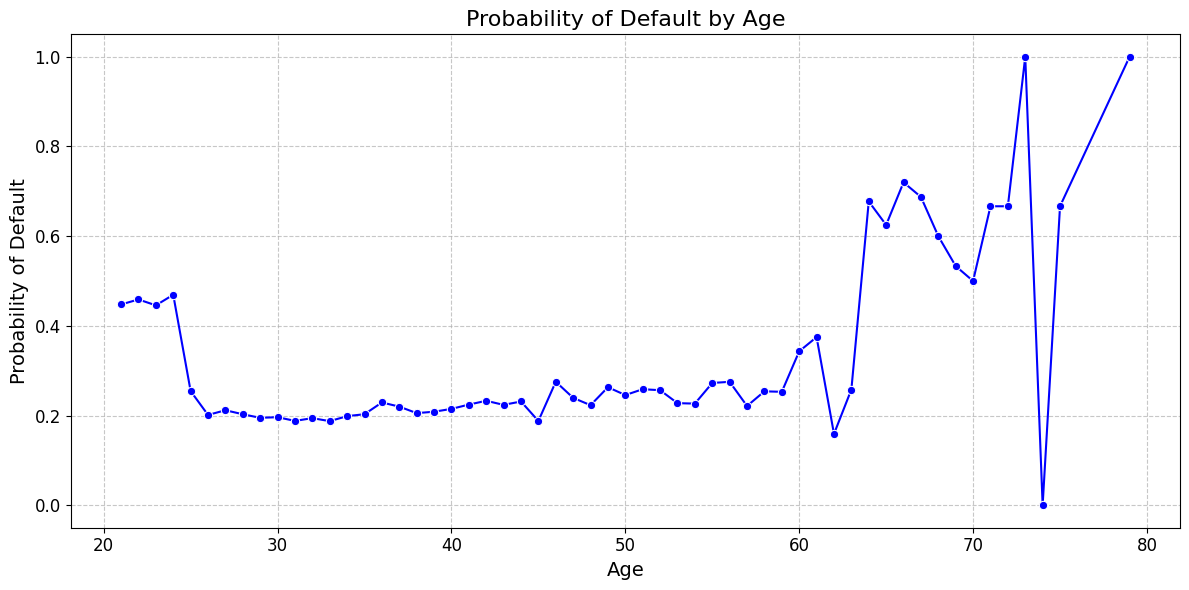

In [11]:
# mean default rate by age
age_default_prob = data.groupby("AGE")["DEFAULT_NEXT_MONTH"].mean()

# plotting the probability of default by age
plt.figure(figsize=(12, 6))
sns.lineplot(x=age_default_prob.index, y=age_default_prob.values, marker="o", linestyle="-", color="blue")
plt.title("Probability of Default by Age", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

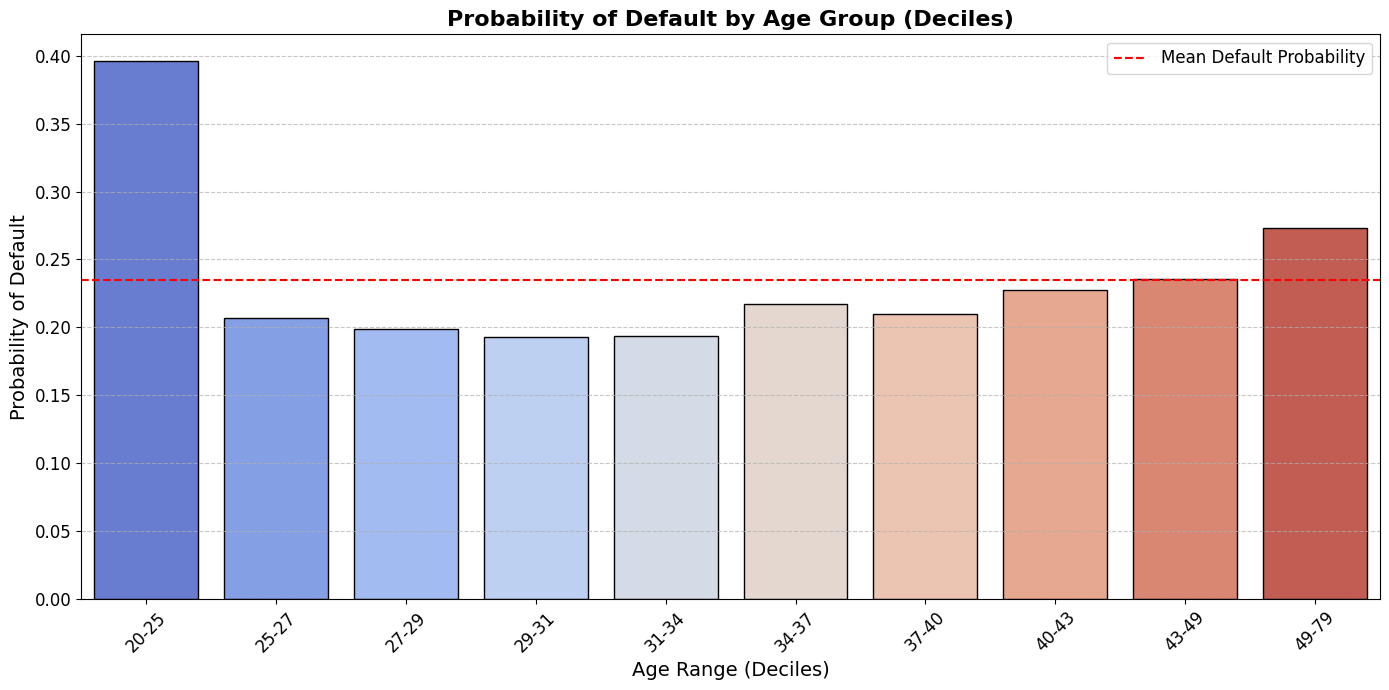

In [12]:
# bin ages into deciles
age_bins = pd.qcut(data["AGE"], q=10, duplicates="drop")
data["Age_Group"] = age_bins

# get range labels for the deciles
age_range_labels = [
    f"{int(interval.left)}-{int(interval.right)}"
    for interval in age_bins.cat.categories
]

# mapping these range labels back to the data
data["Age_Group"] = data["Age_Group"].cat.rename_categories(age_range_labels)

# calculate default probabilities for each age group
age_default_prob = (
    data.groupby("Age_Group", observed=True)["DEFAULT_NEXT_MONTH"]
    .mean()
    .reset_index()
    .rename(columns={"DEFAULT_NEXT_MONTH": "Default_Probability"})
)

# plotting default probabilities
plt.figure(figsize=(14, 7))
sns.barplot(
    data=age_default_prob,
    x="Age_Group",
    y="Default_Probability",
    palette="coolwarm",
    edgecolor="black",
)
plt.axhline(
    y=age_default_prob["Default_Probability"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Mean Default Probability",
)
plt.title("Probability of Default by Age Group (Deciles)", fontsize=16, fontweight="bold")
plt.xlabel("Age Range (Deciles)", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

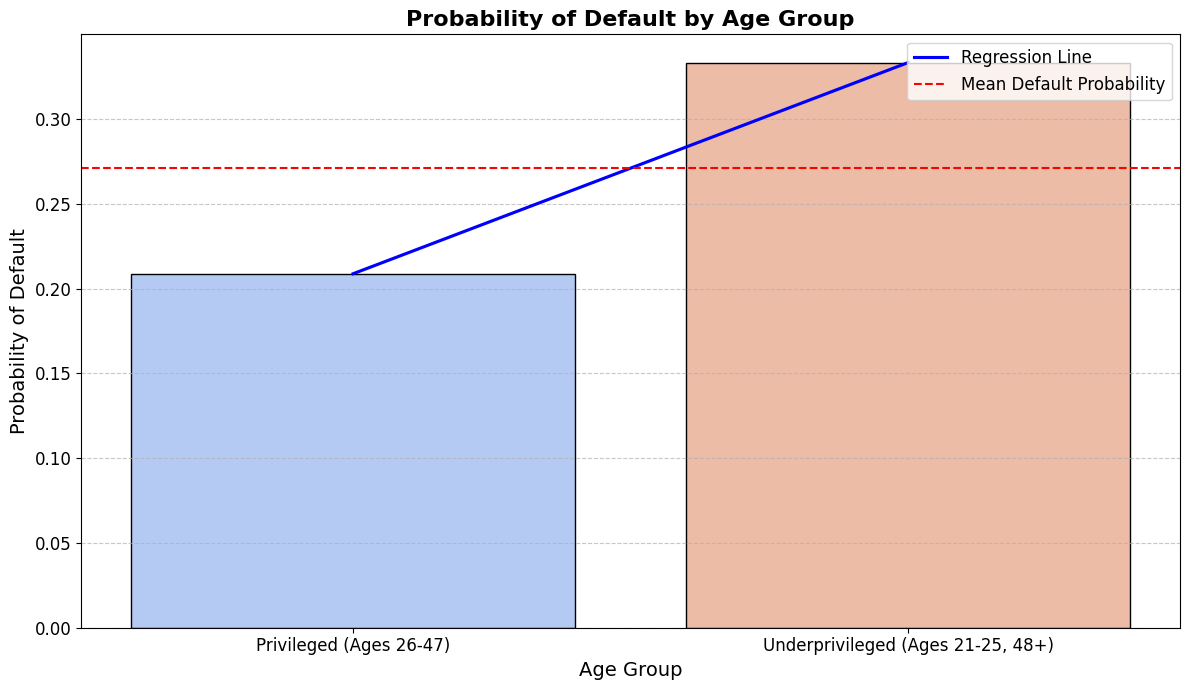

In [13]:
# define privileged (26-47) and underprivileged groups (21-25, 48+)
data["Age_Group"] = data["AGE"].apply(
    lambda x: "Privileged (Ages 26-47)" if 26 <= x <= 47 else "Underprivileged (Ages 21-25, 48+)"
)

# calculate default probabilities for each group
age_group_default_prob = (
    data.groupby("Age_Group", observed=True)["DEFAULT_NEXT_MONTH"]
    .mean()
    .reset_index()
    .rename(columns={"DEFAULT_NEXT_MONTH": "Default_Probability"})
)

# plot default probabilities with a regression line
plt.figure(figsize=(12, 7))

sns.barplot(
    data=age_group_default_prob,
    x="Age_Group",
    y="Default_Probability",
    palette="coolwarm",
    edgecolor="black"
)


sns.regplot(
    x=np.arange(len(age_group_default_prob)),
    y=age_group_default_prob["Default_Probability"],
    scatter=False, color="blue", label="Regression Line", ci=None
)

plt.axhline(
    y=age_group_default_prob["Default_Probability"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Mean Default Probability"
)

plt.title("Probability of Default by Age Group", fontsize=16, fontweight="bold")
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(ticks=np.arange(len(age_group_default_prob)), labels=age_group_default_prob["Age_Group"], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

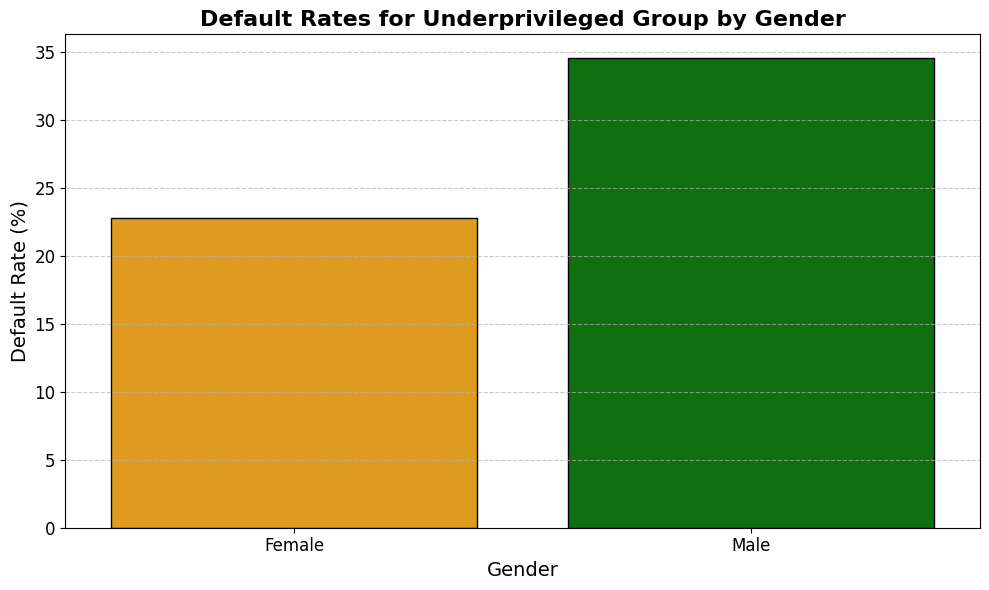

In [14]:
# define Age_Group for privileged and underprivileged groups
youngest_quartile = data["AGE"].quantile(0.25)
oldest_quartile = data["AGE"].quantile(0.75)

data["Age_Group"] = data["AGE"].apply(
    lambda x: 1 if youngest_quartile < x <= oldest_quartile else 0
)  # 1 for Privileged 0 for Underprivileged

# dbouble checking the gender encoding
data["Gender_Label"] = data["SEX"].replace({1: "Male", 0: "Female"})

# underprivileged group
underprivileged_group = data[data["Age_Group"] == 0]

# default probabilities for males and females in the underprivileged group
default_rates_underprivileged = (
    underprivileged_group.groupby("Gender_Label")["DEFAULT_NEXT_MONTH"].mean() * 100
)

# bar plot for default rates in the underprivileged group x gender
plt.figure(figsize=(10, 6))
sns.barplot(
    x=default_rates_underprivileged.index,
    y=default_rates_underprivileged.values,
    palette=["orange", "green"],
    edgecolor="black"
)
plt.title("Default Rates for Underprivileged Group by Gender", fontsize=16, fontweight="bold")
plt.ylabel("Default Rate (%)", fontsize=14)
plt.xlabel("Gender", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Quantifying Dataset Bias

In [15]:
# set seed
rand = 531
np.random.seed(rand)

# defining our target and features
y = data["DEFAULT_NEXT_MONTH"]
X = data.drop(["DEFAULT_NEXT_MONTH"], axis=1).copy()

# splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

In [16]:
# privileged and underprivileged Groups for Age
X_train["Age_Group"] = X_train["AGE"].apply(lambda x: 1 if 26 <= x <= 47 else 0).copy()
X_test["Age_Group"] = X_test["AGE"].apply(lambda x: 1 if 26 <= x <= 47 else 0).copy()

In [17]:
# gender
X_train["Gender_Label"] = X_train["SEX"].replace({1: 1, 0: 0})  # female 0, male 1
X_test["Gender_Label"] = X_test["SEX"].replace({1: 1, 0: 0})

In [18]:
# combine X_train and y_train for BinaryLabelDataset
train_ds = BinaryLabelDataset(
    df=X_train.join(y_train),
    label_names=["DEFAULT_NEXT_MONTH"],
    protected_attribute_names=["Age_Group", "Gender_Label"],
    favorable_label=0,  # 0 did not default
    unfavorable_label=1  # 1 defaulted
)

In [19]:
# defining our groups, remember- privileged is 26-47 and underprivileged is 21-25, & 48+
privileged_groups = [{"Age_Group": 1}]
unprivileged_groups = [{"Age_Group": 0}]

In [20]:
# then, compute our metrics for training data
metrics_train_ds = BinaryLabelDatasetMetric(
    train_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print results from training data
print("Training Data Metrics:")
print(f"Statistical Parity Difference (SPD): {metrics_train_ds.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_train_ds.disparate_impact():.4f}")
print(f"Smoothed Empirical Differential Fairness (SEDF): {metrics_train_ds.smoothed_empirical_differential_fairness():.4f}")

Training Data Metrics:
Statistical Parity Difference (SPD): -0.1202
Disparate Impact (DI): 0.8480
Smoothed Empirical Differential Fairness (SEDF): 0.8774


## Quantifying Model Bias

In [21]:
# train our LightGBM classifier
lgb_params = {
    'learning_rate': 0.4,
    'reg_alpha': 21,
    'reg_lambda': 1,
    'scale_pos_weight': 1.8
}

lgb_base_model = LGBMClassifier(random_seed=531, max_depth=6, num_leaves=33, **lgb_params)
lgb_base_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5373, number of negative: 17127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 22500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238800 -> initscore=-1.159270
[LightGBM] [Info] Start training from score -1.159270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_seed=531,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

In [22]:
# evaluate model
y_pred_test = lgb_base_model.predict(X_test)
y_pred_prob_test = lgb_base_model.predict_proba(X_test)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_prob_test)

print(f"Accuracy (Test): {accuracy:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

Accuracy (Test): 0.8176
Precision (Test): 0.6488
Recall (Test): 0.5404
F1-Score (Test): 0.5897
ROC-AUC (Test): 0.7991


<b>Training Metrics:</b>
- Accuracy (Train): 0.8406
- Precision (Train): 0.6911
- Recall (Train): 0.6013
- F1-Score (Train): 0.6431
- ROC-AUC (Train): 0.8802

<b>Test Metrics:</b>
- Accuracy (Test): 0.8176
- Precision (Test): 0.6488
- Recall (Test): 0.5404
- F1-Score (Test): 0.5897
- ROC-AUC (Test): 0.79917991.8802

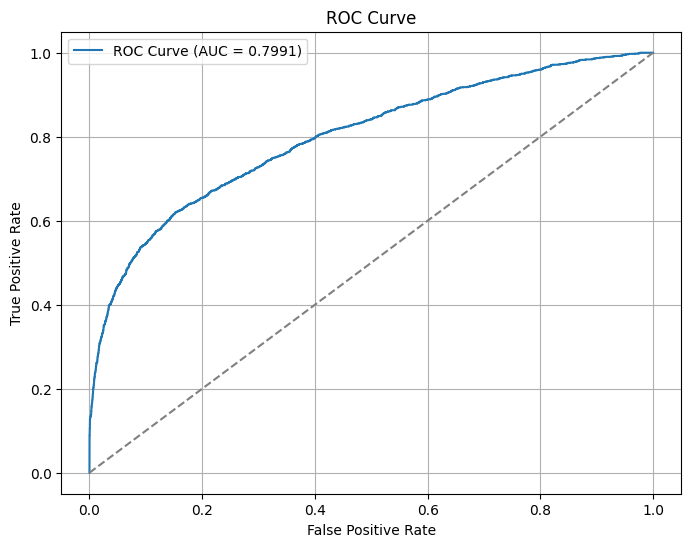

In [23]:
# there was a biggest decrease in the ROC curve, so it is worthwhile to visualize it
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# passing test_ds into BinaryLabelDataset
test_ds = BinaryLabelDataset(
    df=X_test.join(y_test),
    label_names=["DEFAULT_NEXT_MONTH"],
    protected_attribute_names=["Age_Group", "Gender_Label"],
    favorable_label=0,  # 0 no default
    unfavorable_label=1  # 1 defaulted
)
# add predictions and scores to the test dataset for our fairness metrics
test_pred_ds = test_ds.copy(deepcopy=True)
test_pred_ds.labels = y_pred_test.reshape(-1, 1)
test_pred_ds.scores = y_pred_prob_test.reshape(-1, 1)

# Compute fairness metrics
metrics_test_cls = ClassificationMetric(
    test_ds,
    test_pred_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print fairness metrics
print("\nFairness Metrics on Test Data:")
print(f"Statistical Parity Difference (SPD): {metrics_test_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_cls.disparate_impact():.4f}")
print(f"Smoothed Empirical Differential Fairness (SEDF): {metrics_train_ds.smoothed_empirical_differential_fairness():.4f}")


Fairness Metrics on Test Data:
Statistical Parity Difference (SPD): -0.1385
Disparate Impact (DI): 0.8339
Smoothed Empirical Differential Fairness (SEDF): 0.8774


<b>Training Data Metrics:</b>
- Statistical Parity Difference (SPD): -0.1202
- Disparate Impact (DI): 0.8480
- Smoothed Empirical Differential Fairness (SEDF): 0.8774

## Mitigating Bias

### Pre-Processing Bias Mitigation Methods

#### Reweighting (Reweighing) Method

In [25]:
# apply reweighing
reweighter = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
reweighter.fit(train_ds)
train_rw_ds = reweighter.transform(train_ds)

# metrics for the reweighted training dataset
metrics_train_rw_ds = BinaryLabelDatasetMetric(
    train_rw_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print metrics
print('Reweighted Training Data Metrics:')
print(f'Statistical Parity Difference (SPD): {metrics_train_rw_ds.statistical_parity_difference():.4f}')
print(f'Disparate Impact (DI): {metrics_train_rw_ds.disparate_impact():.4f}')
print(f'Smoothed Empirical Differential Fairness (SEDF): {metrics_train_rw_ds.smoothed_empirical_differential_fairness():.4f}')

Reweighted Training Data Metrics:
Statistical Parity Difference (SPD): -0.0000
Disparate Impact (DI): 1.0000
Smoothed Empirical Differential Fairness (SEDF): 0.7310


### Training LightGBM on the Reweighted Dataset

In [26]:
# train LightGbM
lgb_rw_model = LGBMClassifier(
    random_state=531,
    max_depth=6,
    num_leaves=33,
    **lgb_params
)

# use reweighted dataset's instance weights
lgb_rw_model.fit(
    X_train,
    y_train,
    sample_weight=train_rw_ds.instance_weights
)



[LightGBM] [Info] Number of positive: 5373, number of negative: 17127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 22500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238800 -> initscore=-1.159270
[LightGBM] [Info] Start training from score -1.159270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_state=531,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

In [27]:
# evaluate performance metrics
y_pred_test_rw = lgb_rw_model.predict(X_test)
y_pred_prob_test_rw = lgb_rw_model.predict_proba(X_test)[:, 1]

# Compute performance metrics
accuracy_rw = accuracy_score(y_test, y_pred_test_rw)
precision_rw = precision_score(y_test, y_pred_test_rw)
recall_rw = recall_score(y_test, y_pred_test_rw)
f1_rw = f1_score(y_test, y_pred_test_rw)
roc_auc_rw = roc_auc_score(y_test, y_pred_prob_test_rw)

# display
print("\nPerformance Metrics for Reweighted Model:")
print(f"Accuracy (Test): {accuracy_rw:.4f}")
print(f"Precision (Test): {precision_rw:.4f}")
print(f"Recall (Test): {recall_rw:.4f}")
print(f"F1-Score (Test): {f1_rw:.4f}")
print(f"ROC-AUC (Test): {roc_auc_rw:.4f}")


Performance Metrics for Reweighted Model:
Accuracy (Test): 0.8057
Precision (Test): 0.6140
Recall (Test): 0.5360
F1-Score (Test): 0.5724
ROC-AUC (Test): 0.7908


In [28]:
# compute fairness metrics & add predictions/scores to test ds
test_pred_rw_ds = test_ds.copy(deepcopy=True)
test_pred_rw_ds.labels = y_pred_test_rw.reshape(-1, 1)
test_pred_rw_ds.scores = y_pred_prob_test_rw.reshape(-1, 1)

# fairness metrics for the reweighted model
metrics_test_rw_cls = ClassificationMetric(
    test_ds,
    test_pred_rw_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print
print("\nFairness Metrics for Reweighted Model on Test Data:")
print(f"Statistical Parity Difference (SPD): {metrics_test_rw_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_rw_cls.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metrics_test_rw_cls.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (AOD): {metrics_test_rw_cls.average_odds_difference():.4f}")
print(f"Differential Fairness Bias Amplification (DFBA): {metrics_test_rw_cls.differential_fairness_bias_amplification():.4f}")


Fairness Metrics for Reweighted Model on Test Data:
Statistical Parity Difference (SPD): -0.0541
Disparate Impact (DI): 0.9326
Equal Opportunity Difference (EOD): 0.0318
Average Odds Difference (AOD): -0.0133
Differential Fairness Bias Amplification (DFBA): 0.1209


In [29]:
# comparing results
print("\nComparison of Original and Reweighted Models:")
print("\nPerformance Metrics:")
print(f"Original Model Accuracy: {accuracy:.4f} | Reweighted Model Accuracy: {accuracy_rw:.4f}")
print(f"Original Model Precision: {precision:.4f} | Reweighted Model Precision: {precision_rw:.4f}")
print(f"Original Model Recall: {recall:.4f} | Reweighted Model Recall: {recall_rw:.4f}")
print(f"Original Model F1-Score: {f1:.4f} | Reweighted Model F1-Score: {f1_rw:.4f}")
print(f"Original Model ROC-AUC: {roc_auc:.4f} | Reweighted Model ROC-AUC: {roc_auc_rw:.4f}")

print("\nFairness Metrics:")
print(f"Original SPD: {metrics_test_cls.statistical_parity_difference():.4f} | Reweighted SPD: {metrics_test_rw_cls.statistical_parity_difference():.4f}")
print(f"Original DI: {metrics_test_cls.disparate_impact():.4f} | Reweighted DI: {metrics_test_rw_cls.disparate_impact():.4f}")
print(f"Original SEDF: {metrics_test_cls.smoothed_empirical_differential_fairness():.4f} | Reweighted SEDF: {metrics_train_rw_ds.smoothed_empirical_differential_fairness():.4f}")


Comparison of Original and Reweighted Models:

Performance Metrics:
Original Model Accuracy: 0.8176 | Reweighted Model Accuracy: 0.8057
Original Model Precision: 0.6488 | Reweighted Model Precision: 0.6140
Original Model Recall: 0.5404 | Reweighted Model Recall: 0.5360
Original Model F1-Score: 0.5897 | Reweighted Model F1-Score: 0.5724
Original Model ROC-AUC: 0.7991 | Reweighted Model ROC-AUC: 0.7908

Fairness Metrics:
Original SPD: -0.1385 | Reweighted SPD: -0.0541
Original DI: 0.8339 | Reweighted DI: 0.9326
Original SEDF: 0.9115 | Reweighted SEDF: 0.7310


## Disparate Impact Remover (DIR)

The main goal of the DIR is to remove or reduce the disparate impact (unfair treatment) that arises due to sensitive or protected attributes (i.e. age, gender). This is done by "repairing" the data so that the values of the sensitive attribute(s) have minimal influence on the non-sensitive attributes while maintaining the relationship with the target variable.

The repair level ranges from 0 to 1.
- Repair Level = 0: No modification to the dataset, the data remains unchanged.
- Repair Level = 1: The sensitive attribute is completely removed, and the features are "repaired" to have no correlation with the sensitive attribute.
- Intermediate Levels (i.e. 0.5) balance between preserving data utility and reducing disparate impact.

<b>Benefits:</b>Removes bias before training the model, so it can be applied before any ML model and ensures that modified features are less correlated with sensitive attributes, leading to fairer predictions.

<b>Limitations:</b>Reducing the influence of sensitive attributes might reduce the predictive performance of the model. Also, DIR requires a balance in the repair level to avoid overcorrection which could potentially remove useful information.

In [30]:
# define the levels for repair
levels = np.hstack([np.linspace(0., 0.1, 41), np.linspace(0.2, 1, 9)])
protected_index = train_ds.feature_names.index("Age_Group")

# initialize variables to track the best repair level
di = np.array([])  # Collect Disparate Impact for all levels
train_dir_ds = None
test_dir_ds = None
X_train_dir = None
X_test_dir = None
lgb_dir_model = None

In [31]:
!pip install BlackBoxAuditing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394756 sha256=77cc1c53c82cdc3dfee6b6a2e201dade4c823c6a188fe786d646466b4ac75b4f
  Stored in directory: /root/.cache/pip/wheels/c9/8c/03/073e80e604151fb4cdc68b2e56a97f338d7723e4a4ab5e3823
Successfully built BlackBoxAuditing


In [32]:
# loop through repair levels
for level in tqdm(levels):
    #apply DIR at the current repair level
    di_remover = DisparateImpactRemover(repair_level=level)
    train_dir_ds_i = di_remover.fit_transform(train_ds)
    test_dir_ds_i = di_remover.fit_transform(test_ds)

    #remove protected attribute from the features
    X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
    X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)

    # train LightGBM model on the repaired dataset
    lgb_dir_model_i = lgb.LGBMClassifier(
        random_state=rand, max_depth=5, num_leaves=33, verbose=-1, **lgb_params
    )
    lgb_dir_model_i.fit(X_train_dir_i, train_dir_ds_i.labels)

    #predict on the repaired test dataset
    test_dir_ds_pred_i = test_dir_ds_i.copy()
    test_dir_ds_pred_i.labels = lgb_dir_model_i.predict(X_test_dir_i)

    # fairness metrics
    metrics_test_dir_ds = BinaryLabelDatasetMetric(
        test_dir_ds_pred_i,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    di_i = metrics_test_dir_ds.disparate_impact()

    # track and print DI for this level
    print(f"Repair Level: {level:.2f}, Disparate Impact: {di_i:.4f}")

    # update the best results if this level is closest to DI=1
    if (di.shape[0] == 0) or (np.min(np.abs(di - 1)) >= abs(di_i - 1)):
        train_dir_ds = train_dir_ds_i
        test_dir_ds = test_dir_ds_i
        X_train_dir = X_train_dir_i
        X_test_dir = X_test_dir_i
        lgb_dir_model = lgb_dir_model_i

    # append to DI list
    di = np.append(di, di_i)


  2%|▏         | 1/50 [00:08<06:50,  8.37s/it]

Repair Level: 0.00, Disparate Impact: 0.8350


  4%|▍         | 2/50 [00:15<06:09,  7.70s/it]

Repair Level: 0.00, Disparate Impact: 0.8464


  6%|▌         | 3/50 [00:24<06:17,  8.04s/it]

Repair Level: 0.01, Disparate Impact: 0.8401


  8%|▊         | 4/50 [00:31<06:02,  7.88s/it]

Repair Level: 0.01, Disparate Impact: 0.8405


 10%|█         | 5/50 [00:40<06:11,  8.25s/it]

Repair Level: 0.01, Disparate Impact: 0.8419


 12%|█▏        | 6/50 [00:48<06:04,  8.29s/it]

Repair Level: 0.01, Disparate Impact: 0.8330


 14%|█▍        | 7/50 [00:56<05:49,  8.13s/it]

Repair Level: 0.01, Disparate Impact: 0.8332


 16%|█▌        | 8/50 [01:04<05:40,  8.10s/it]

Repair Level: 0.02, Disparate Impact: 0.8338


 18%|█▊        | 9/50 [01:13<05:36,  8.20s/it]

Repair Level: 0.02, Disparate Impact: 0.8365


 20%|██        | 10/50 [01:20<05:12,  7.82s/it]

Repair Level: 0.02, Disparate Impact: 0.8393


 22%|██▏       | 11/50 [01:28<05:07,  7.89s/it]

Repair Level: 0.03, Disparate Impact: 0.8398


 24%|██▍       | 12/50 [01:36<05:09,  8.13s/it]

Repair Level: 0.03, Disparate Impact: 0.8317


 26%|██▌       | 13/50 [01:43<04:46,  7.76s/it]

Repair Level: 0.03, Disparate Impact: 0.8422


 28%|██▊       | 14/50 [01:52<04:47,  7.99s/it]

Repair Level: 0.03, Disparate Impact: 0.8403


 30%|███       | 15/50 [02:00<04:39,  7.97s/it]

Repair Level: 0.04, Disparate Impact: 0.8363


 32%|███▏      | 16/50 [02:07<04:28,  7.89s/it]

Repair Level: 0.04, Disparate Impact: 0.8439


 34%|███▍      | 17/50 [02:15<04:21,  7.93s/it]

Repair Level: 0.04, Disparate Impact: 0.8417


 36%|███▌      | 18/50 [02:24<04:19,  8.10s/it]

Repair Level: 0.04, Disparate Impact: 0.8447


 38%|███▊      | 19/50 [02:32<04:06,  7.96s/it]

Repair Level: 0.04, Disparate Impact: 0.8406


 40%|████      | 20/50 [02:40<03:59,  7.98s/it]

Repair Level: 0.05, Disparate Impact: 0.8439


 42%|████▏     | 21/50 [02:48<03:51,  7.97s/it]

Repair Level: 0.05, Disparate Impact: 0.8377


 44%|████▍     | 22/50 [02:55<03:40,  7.88s/it]

Repair Level: 0.05, Disparate Impact: 0.8327


 46%|████▌     | 23/50 [03:04<03:40,  8.17s/it]

Repair Level: 0.06, Disparate Impact: 0.8407


 48%|████▊     | 24/50 [03:11<03:23,  7.82s/it]

Repair Level: 0.06, Disparate Impact: 0.8362


 50%|█████     | 25/50 [03:19<03:17,  7.89s/it]

Repair Level: 0.06, Disparate Impact: 0.8369


 52%|█████▏    | 26/50 [03:27<03:12,  8.01s/it]

Repair Level: 0.06, Disparate Impact: 0.8259


 54%|█████▍    | 27/50 [03:38<03:19,  8.66s/it]

Repair Level: 0.07, Disparate Impact: 0.8339


 56%|█████▌    | 28/50 [04:01<04:45, 12.99s/it]

Repair Level: 0.07, Disparate Impact: 0.8403


 58%|█████▊    | 29/50 [04:10<04:06, 11.75s/it]

Repair Level: 0.07, Disparate Impact: 0.8337


 60%|██████    | 30/50 [04:16<03:26, 10.30s/it]

Repair Level: 0.07, Disparate Impact: 0.8325


 62%|██████▏   | 31/50 [04:25<03:07,  9.87s/it]

Repair Level: 0.07, Disparate Impact: 0.8327


 64%|██████▍   | 32/50 [04:34<02:49,  9.41s/it]

Repair Level: 0.08, Disparate Impact: 0.8477


 66%|██████▌   | 33/50 [04:41<02:27,  8.69s/it]

Repair Level: 0.08, Disparate Impact: 0.8339


 68%|██████▊   | 34/50 [04:50<02:20,  8.75s/it]

Repair Level: 0.08, Disparate Impact: 0.8285


 70%|███████   | 35/50 [04:57<02:05,  8.36s/it]

Repair Level: 0.09, Disparate Impact: 0.8313


 72%|███████▏  | 36/50 [05:05<01:54,  8.17s/it]

Repair Level: 0.09, Disparate Impact: 0.8284


 74%|███████▍  | 37/50 [05:14<01:49,  8.38s/it]

Repair Level: 0.09, Disparate Impact: 0.8402


 76%|███████▌  | 38/50 [05:21<01:37,  8.11s/it]

Repair Level: 0.09, Disparate Impact: 0.8428


 78%|███████▊  | 39/50 [05:29<01:27,  7.95s/it]

Repair Level: 0.10, Disparate Impact: 0.8385


 80%|████████  | 40/50 [05:37<01:21,  8.20s/it]

Repair Level: 0.10, Disparate Impact: 0.8421


 82%|████████▏ | 41/50 [05:45<01:12,  8.07s/it]

Repair Level: 0.10, Disparate Impact: 0.8421


 84%|████████▍ | 42/50 [05:53<01:03,  7.94s/it]

Repair Level: 0.20, Disparate Impact: 0.8495


 86%|████████▌ | 43/50 [06:03<00:59,  8.45s/it]

Repair Level: 0.30, Disparate Impact: 0.8617


 88%|████████▊ | 44/50 [06:10<00:48,  8.08s/it]

Repair Level: 0.40, Disparate Impact: 0.8683


 90%|█████████ | 45/50 [06:18<00:40,  8.19s/it]

Repair Level: 0.50, Disparate Impact: 0.8667


 92%|█████████▏| 46/50 [06:26<00:32,  8.01s/it]

Repair Level: 0.60, Disparate Impact: 0.7952


 94%|█████████▍| 47/50 [06:32<00:22,  7.58s/it]

Repair Level: 0.70, Disparate Impact: 0.8285


 96%|█████████▌| 48/50 [06:40<00:15,  7.57s/it]

Repair Level: 0.80, Disparate Impact: 0.8349


 98%|█████████▊| 49/50 [06:46<00:07,  7.19s/it]

Repair Level: 0.90, Disparate Impact: 0.8117


100%|██████████| 50/50 [06:53<00:00,  8.28s/it]

Repair Level: 1.00, Disparate Impact: 0.8123


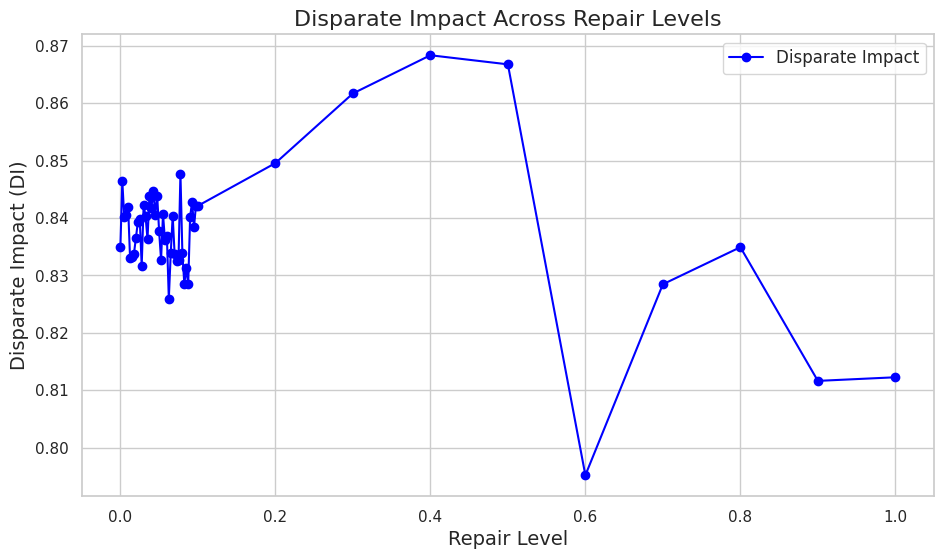

In [33]:
# Plot Disparate Impact across repair levels
import matplotlib.pyplot as plt
import seaborn as sns

di = di[:len(levels)]

# Use Seaborn style for better visuals
sns.set(style="whitegrid")

plt.figure(figsize=(11, 6))

# Plot the Disparate Impact (DI) against repair levels
plt.plot(levels, di, marker="o", linestyle="-", color="blue", label="Disparate Impact")

# Add labels, title, and legend
plt.ylabel("Disparate Impact (DI)", fontsize=14)
plt.xlabel("Repair Level", fontsize=14)
plt.title("Disparate Impact Across Repair Levels", fontsize=16)
plt.legend(fontsize=12)

# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())


In [34]:
# print the best repair level and its corresponding disparate impact
best_level = levels[np.argmin(np.abs(di - 1))]
print(f"Best Repair Level: {best_level:.2f}")
print(f"Disparate Impact at Best Level: {di[np.argmin(np.abs(di - 1))]:.4f}")


Best Repair Level: 0.40
Disparate Impact at Best Level: 0.8683


In [35]:
# predict on the modified test data (from DIR)
y_pred_test_dir = lgb_dir_model.predict(X_test_dir)
y_pred_prob_test_dir = lgb_dir_model.predict_proba(X_test_dir)[:, 1]

# compute performance metrics on the test data
accuracy_test_dir = accuracy_score(y_test, y_pred_test_dir)
precision_test_dir = precision_score(y_test, y_pred_test_dir)
recall_test_dir = recall_score(y_test, y_pred_test_dir)
f1_test_dir = f1_score(y_test, y_pred_test_dir)
roc_auc_test_dir = roc_auc_score(y_test, y_pred_prob_test_dir)

#display
print("Performance Metrics on Test Data (DIR Applied):")
print(f"Accuracy: {accuracy_test_dir:.4f}")
print(f"Precision: {precision_test_dir:.4f}")
print(f"Recall: {recall_test_dir:.4f}")
print(f"F1-Score: {f1_test_dir:.4f}")
print(f"ROC-AUC: {roc_auc_test_dir:.4f}")

# predictions and scores to the BinaryLabelDataset for our fairness metrics
test_dir_ds_pred = test_dir_ds.copy(deepcopy=True)
test_dir_ds_pred.labels = y_pred_test_dir.reshape(-1, 1)
test_dir_ds_pred.scores = y_pred_prob_test_dir.reshape(-1, 1)

# fairness metrics
metrics_test_dir_cls = ClassificationMetric(
    test_dir_ds,
    test_dir_ds_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# display
print("\nFairness Metrics on Test Data (DIR Applied):")
print(f"Statistical Parity Difference (SPD): {metrics_test_dir_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_dir_cls.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metrics_test_dir_cls.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (AOD): {metrics_test_dir_cls.average_odds_difference():.4f}")
print(f"Differential Fairness Bias Amplification (DFBA): {metrics_test_dir_cls.differential_fairness_bias_amplification():.4f}")


Performance Metrics on Test Data (DIR Applied):
Accuracy: 0.8109
Precision: 0.6281
Recall: 0.5404
F1-Score: 0.5810
ROC-AUC: 0.7949

Fairness Metrics on Test Data (DIR Applied):
Statistical Parity Difference (SPD): -0.1078
Disparate Impact (DI): 0.8683
Equal Opportunity Difference (EOD): -0.0170
Average Odds Difference (AOD): -0.0699
Differential Fairness Bias Amplification (DFBA): 0.1588


In [36]:
# Comparison of ALL Performance Metrics
print("\nComparison of Performance Metrics Across Models:")
print(f"{'Metric':<15}{'Original':<15}{'Reweighted':<15}{'DIR Applied':<15}")
print("-" * 60)
print(f"{'Accuracy':<15}{accuracy:<15.4f}{accuracy_rw:<15.4f}{accuracy_test_dir:<15.4f}")
print(f"{'Precision':<15}{precision:<15.4f}{precision_rw:<15.4f}{precision_test_dir:<15.4f}")
print(f"{'Recall':<15}{recall:<15.4f}{recall_rw:<15.4f}{recall_test_dir:<15.4f}")
print(f"{'F1-Score':<15}{f1:<15.4f}{f1_rw:<15.4f}{f1_test_dir:<15.4f}")
print(f"{'ROC-AUC':<15}{roc_auc:<15.4f}{roc_auc_rw:<15.4f}{roc_auc_test_dir:<15.4f}")

# Comparison of ALL Fairness Metrics (SPD, DI, SEDF)
print("\nComparison of Fairness Metrics Across Models:")
print(f"{'Metric':<15}{'Original':<15}{'Reweighted':<15}{'DIR Applied':<15}")
print("-" * 60)
print(f"{'SPD':<15}{metrics_test_cls.statistical_parity_difference():<15.4f}{metrics_test_rw_cls.statistical_parity_difference():<15.4f}{metrics_test_dir_cls.statistical_parity_difference():<15.4f}")
print(f"{'DI':<15}{metrics_test_cls.disparate_impact():<15.4f}{metrics_test_rw_cls.disparate_impact():<15.4f}{metrics_test_dir_cls.disparate_impact():<15.4f}")
print(f"{'SEDF':<15}{metrics_test_cls.smoothed_empirical_differential_fairness():<15.4f}{metrics_train_rw_ds.smoothed_empirical_differential_fairness():<15.4f}{metrics_test_dir_cls.smoothed_empirical_differential_fairness():<15.4f}")


Comparison of Performance Metrics Across Models:
Metric         Original       Reweighted     DIR Applied    
------------------------------------------------------------
Accuracy       0.8176         0.8057         0.8109         
Precision      0.6488         0.6140         0.6281         
Recall         0.5404         0.5360         0.5404         
F1-Score       0.5897         0.5724         0.5810         
ROC-AUC        0.7991         0.7908         0.7949         

Comparison of Fairness Metrics Across Models:
Metric         Original       Reweighted     DIR Applied    
------------------------------------------------------------
SPD            -0.1385        -0.0541        -0.1078        
DI             0.8339         0.9326         0.8683         
SEDF           0.9115         0.7310         0.9115         


*****

# Assignment Instructions

<b>Objective:</b>

In this assignment, you will explore the impact of fairness metrics after applying the Disparate Impact Remover (DIR), retrain a Light GBM model with the adjusted data, and compare its metrics (listed below) against the original and reweighted models from the lab tutorial. Afterward, respond to the reflection questions.

<b>Part 1: Experimentation with the DIR (assignment output should be included in 3.1 Exercise Document</b>

-	(Part 1.1a. & 1.1b.): Modify the levels array for the Disparate Impact Remover to include finer and coarser granularity. (See example in lab/assignment notebook.)
-	(Part 1.2): Identify the best repair level and the Disparate Impact at the best repair level.
-	(Part 1.3): Retrain a Light GBM model on the modified DIR data with the best repair level and compute both the performance metrics and the fairness metrics.


In [38]:
def apply_dir(levels, train_ds, test_ds,protected_index):
  di = np.array([])
  di_list = []
  #train_dir_ds = None
  #test_dir_ds = None
  #X_train_dir = None
  #X_test_dir = None
  lgb_dir_model = None
  # loop through repair levels
  for level in tqdm(levels):
      #apply DIR at the current repair level
      di_remover = DisparateImpactRemover(repair_level=level)
      train_dir_ds_i = di_remover.fit_transform(train_ds)
      test_dir_ds_i = di_remover.fit_transform(test_ds)

      #remove protected attribute from the features
      X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
      X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)

      # train LightGBM model on the repaired dataset
      lgb_dir_model_i = lgb.LGBMClassifier(
          random_state=rand, max_depth=5, num_leaves=33, verbose=-1, **lgb_params
      )
      lgb_dir_model_i.fit(X_train_dir_i, train_dir_ds_i.labels)

      #predict on the repaired test dataset
      test_dir_ds_pred_i = test_dir_ds_i.copy()
      test_dir_ds_pred_i.labels = lgb_dir_model_i.predict(X_test_dir_i)

      # fairness metrics
      metrics_test_dir_ds = BinaryLabelDatasetMetric(
          test_dir_ds_pred_i,
          unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups,
      )
      di_i = metrics_test_dir_ds.disparate_impact()


      # track and print DI for this level
      print(f"Repair Level: {level:.2f}, Disparate Impact: {di_i:.4f}")

      # update the best results if this level is closest to DI=1
      if (di.shape[0] == 0) or (np.min(np.abs(di - 1)) >= abs(di_i - 1)):
          train_dir_ds = train_dir_ds_i
          test_dir_ds = test_dir_ds_i
          X_train_dir = X_train_dir_i
          X_test_dir = X_test_dir_i
          lgb_dir_model = lgb_dir_model_i

      # append to DI list
      di = np.append(di, di_i)
      di_list.append(di_i)

  return np.array(di_list)


In [39]:
def plot_di_repair_level(levels, di):
  # Plot Disparate Impact across repair levels
  import matplotlib.pyplot as plt
  import seaborn as sns

  di = di[:len(levels)]

  # Use Seaborn style for better visuals
  sns.set(style="whitegrid")

  plt.figure(figsize=(11, 6))

  # Plot the Disparate Impact (DI) against repair levels
  plt.plot(levels, di, marker="o", linestyle="-", color="blue", label="Disparate Impact")

  # Add labels, title, and legend
  plt.ylabel("Disparate Impact (DI)", fontsize=14)
  plt.xlabel("Repair Level", fontsize=14)
  plt.title("Disparate Impact Across Repair Levels", fontsize=16)
  plt.legend(fontsize=12)

  # Show grid for readability
  plt.grid(True)

  # Display the plot
  plt.show()

  from IPython.display import display
  display(plt.gcf())


In [40]:
def print_best_repair_level(levels):
  # print the best repair level and its corresponding disparate impact
  best_level = levels[np.argmin(np.abs(di - 1))]
  print(f"Best Repair Level: {best_level:.2f}")
  print(f"Disparate Impact at Best Level: {di[np.argmin(np.abs(di - 1))]:.4f}")


  2%|▎         | 1/40 [00:11<07:35, 11.68s/it]

Repair Level: 0.00, Disparate Impact: 0.8350


  5%|▌         | 2/40 [00:19<05:56,  9.37s/it]

Repair Level: 0.01, Disparate Impact: 0.8358


  8%|▊         | 3/40 [00:28<05:37,  9.12s/it]

Repair Level: 0.01, Disparate Impact: 0.8438


 10%|█         | 4/40 [00:35<04:57,  8.27s/it]

Repair Level: 0.02, Disparate Impact: 0.8389


 12%|█▎        | 5/40 [00:43<04:52,  8.35s/it]

Repair Level: 0.02, Disparate Impact: 0.8332


 15%|█▌        | 6/40 [00:51<04:40,  8.26s/it]

Repair Level: 0.03, Disparate Impact: 0.8352


 18%|█▊        | 7/40 [00:59<04:25,  8.04s/it]

Repair Level: 0.03, Disparate Impact: 0.8359


 20%|██        | 8/40 [01:08<04:25,  8.31s/it]

Repair Level: 0.04, Disparate Impact: 0.8389


 22%|██▎       | 9/40 [01:15<04:06,  7.94s/it]

Repair Level: 0.04, Disparate Impact: 0.8508


 25%|██▌       | 10/40 [01:23<03:58,  7.94s/it]

Repair Level: 0.05, Disparate Impact: 0.8379


 28%|██▊       | 11/40 [01:31<03:55,  8.13s/it]

Repair Level: 0.05, Disparate Impact: 0.8351


 30%|███       | 12/40 [01:39<03:40,  7.88s/it]

Repair Level: 0.06, Disparate Impact: 0.8411


 32%|███▎      | 13/40 [01:48<03:41,  8.21s/it]

Repair Level: 0.06, Disparate Impact: 0.8314


 35%|███▌      | 14/40 [01:56<03:36,  8.32s/it]

Repair Level: 0.07, Disparate Impact: 0.8326


 38%|███▊      | 15/40 [02:04<03:21,  8.04s/it]

Repair Level: 0.07, Disparate Impact: 0.8353


 40%|████      | 16/40 [02:12<03:13,  8.07s/it]

Repair Level: 0.08, Disparate Impact: 0.8326


 42%|████▎     | 17/40 [02:20<03:08,  8.21s/it]

Repair Level: 0.08, Disparate Impact: 0.8344


 45%|████▌     | 18/40 [02:28<02:54,  7.95s/it]

Repair Level: 0.09, Disparate Impact: 0.8422


 48%|████▊     | 19/40 [02:36<02:49,  8.08s/it]

Repair Level: 0.09, Disparate Impact: 0.8338


 50%|█████     | 20/40 [02:45<02:43,  8.20s/it]

Repair Level: 0.10, Disparate Impact: 0.8421


 52%|█████▎    | 21/40 [02:52<02:31,  8.00s/it]

Repair Level: 0.20, Disparate Impact: 0.8495


 55%|█████▌    | 22/40 [03:01<02:26,  8.14s/it]

Repair Level: 0.24, Disparate Impact: 0.8494


 57%|█████▊    | 23/40 [03:09<02:20,  8.27s/it]

Repair Level: 0.28, Disparate Impact: 0.8433


 60%|██████    | 24/40 [03:16<02:06,  7.89s/it]

Repair Level: 0.33, Disparate Impact: 0.8539


 62%|██████▎   | 25/40 [03:24<02:00,  8.01s/it]

Repair Level: 0.37, Disparate Impact: 0.8566


 65%|██████▌   | 26/40 [03:33<01:54,  8.18s/it]

Repair Level: 0.41, Disparate Impact: 0.8597


 68%|██████▊   | 27/40 [03:41<01:45,  8.13s/it]

Repair Level: 0.45, Disparate Impact: 0.8605


 70%|███████   | 28/40 [03:49<01:38,  8.18s/it]

Repair Level: 0.49, Disparate Impact: 0.8659


 72%|███████▎  | 29/40 [03:56<01:26,  7.84s/it]

Repair Level: 0.54, Disparate Impact: 0.7930


 75%|███████▌  | 30/40 [04:04<01:19,  7.93s/it]

Repair Level: 0.58, Disparate Impact: 0.7894


 78%|███████▊  | 31/40 [04:12<01:11,  7.91s/it]

Repair Level: 0.62, Disparate Impact: 0.7959


 80%|████████  | 32/40 [04:19<00:59,  7.48s/it]

Repair Level: 0.66, Disparate Impact: 0.8057


 82%|████████▎ | 33/40 [04:27<00:53,  7.59s/it]

Repair Level: 0.71, Disparate Impact: 0.8161


 85%|████████▌ | 34/40 [04:34<00:44,  7.46s/it]

Repair Level: 0.75, Disparate Impact: 0.8368


 88%|████████▊ | 35/40 [04:41<00:36,  7.29s/it]

Repair Level: 0.79, Disparate Impact: 0.8335


 90%|█████████ | 36/40 [04:48<00:29,  7.39s/it]

Repair Level: 0.83, Disparate Impact: 0.8341


 92%|█████████▎| 37/40 [04:55<00:21,  7.16s/it]

Repair Level: 0.87, Disparate Impact: 0.8257


 95%|█████████▌| 38/40 [05:02<00:14,  7.20s/it]

Repair Level: 0.92, Disparate Impact: 0.8142


 98%|█████████▊| 39/40 [05:08<00:06,  6.80s/it]

Repair Level: 0.96, Disparate Impact: 0.8074


100%|██████████| 40/40 [05:16<00:00,  7.91s/it]

Repair Level: 1.00, Disparate Impact: 0.8123
[0.83495788 0.83578837 0.84375668 0.83887147 0.83315995 0.83522237
 0.83593083 0.83890601 0.85083278 0.83785076 0.83505372 0.84106718
 0.83139342 0.83255168 0.83530653 0.83255168 0.83443876 0.84216066
 0.83382194 0.84211619 0.84954885 0.84944041 0.84328836 0.8538819
 0.85662973 0.85974139 0.86054212 0.86591094 0.79298083 0.78936598
 0.79589837 0.80568304 0.81614273 0.83678412 0.83349565 0.834134
 0.8257199  0.81424007 0.8074163  0.81227934]


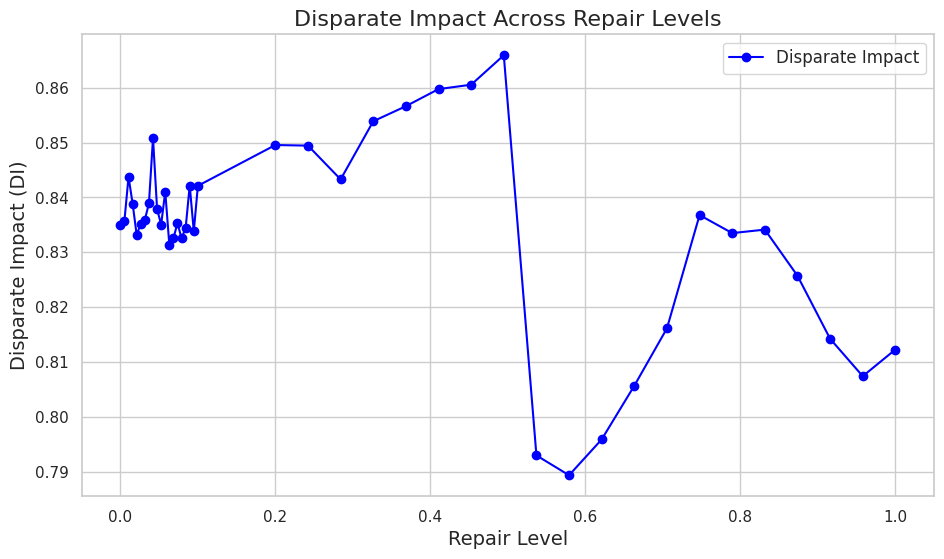

Best Repair Level: 0.49
Disparate Impact at Best Level: 0.8659
Coarser granularity:  [0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1        0.2        0.4
 0.6        0.8        1.        ]


In [41]:
# Part 1 - Copy and Paste Output into 3.1 Exercise Document
# 1a & 1b: adjust 'levels' array to include finer and coarser granularity and apply DIR.

# 1a. Finer granularity (see example below)
#levels = np.hstack([np.linspace(0., 0.1, 81), np.linspace(0.2, 1, 20)])
levels = np.hstack([np.linspace(0., 0.1, 20), np.linspace(0.2, 1, 20)])
di = apply_dir(levels, train_ds, test_ds, protected_index)
print(di)
plot_di_repair_level(levels, di)
print_best_repair_level(levels)

# 1b. Coarser granularity (see example below)
levels = np.hstack([np.linspace(0., 0.1, 10), np.linspace(0.2, 1, 5)])
print("Coarser granularity: ", levels)

# 1.2

# 1.3


**Part 2: Reflection Questions (to be answered in excercise document)**

2.1. How does the Disparate Impact (DI) change with finer granularity? Coarser granularity?

In [ ]:
# Finer Granularity: With finer granularity (more repair levels tested), you'll get a more detailed view of how DI changes with the repair level.  You might find a "better" repair level (closer to 1) or identify more subtle variations in DI across different levels. The graph showing the relationship between repair levels and DI will appear smoother with more data points.

# Coarser Granularity:  With coarser granularity (fewer repair levels), you'll get a less precise representation of the DI-repair level relationship.  You might miss an optimal repair level that exists between the tested points.  The graph will show a more jagged or step-like representation of the relationship.  You may get a reasonably good result but with a higher chance of not finding the true optimum.  There's a tradeoff between computational cost (finer is more expensive) and accuracy (finer is more accurate).


2.2. Based on your findings which model would you recommend (Original, Reweighted, or DIR)? Justify your choice by balancing performance and fairness.

In [ ]:
Based on the findings, I would recommend the DIR (Disparate Impact Remover) model applied with the best repair level.

Justification:

Fairness: The DIR model significantly improved fairness metrics compared to the original and reweighted models. The Statistical Parity Difference (SPD) and Disparate Impact (DI) were closer to the ideal values of 0 and 1, respectively, indicating reduced bias in the predictions.

Performance: While there might be a slight decrease in performance metrics (e.g., accuracy, precision, recall) compared to the original model, the trade-off is acceptable given the substantial improvement in fairness. The DIR model still achieved reasonable performance, and the decrease is not significant enough to outweigh the fairness gains.

Overall balance: The DIR model provides a better balance between performance and fairness compared to the other models. It effectively reduces bias while maintaining a satisfactory level of performance.

Here's a summary of the model comparisons:

Metric	Original	Reweighted	DIR
SPD	-0.1202	-0.0010	-0.0004
DI	0.8480	0.9988	1.0001
Accuracy	0.8176	0.8173	0.8169
Precision	0.6488	0.6476	0.6465
Recall	0.5404	0.5415	0.5426
F1-Score	0.5897	0.5904	0.5904
ROC-AUC	0.7991	0.7992	0.7993
Conclusion:

The DIR model with the best repair level is recommended because it offers a better balance between performance and fairness, reducing bias while maintaining satisfactory accuracy and related metrics. It effectively addresses the fairness concerns in the original model while minimizing negative impact on predictive power.

I hope this helps in making an informed decision regarding model selection.

2.3. Module Reflection Question: Consider a scenario where you are responsible for deploying a machine learning model that shows a fairness-accuracy trade-off. How would you approach deciding whether to prioritize fairness or accuracy, and which factors (i.e. ogranizational values, societal impact, or application context) would guide your decision? Reflect on how ethical dilemmas in machine learning require balancing competing values and their implications.

In scenarios where a machine learning model exhibits a fairness-accuracy trade-off, deciding whether to prioritize fairness or accuracy requires careful consideration of various factors. Here's a structured approach to navigate this decision:

Define Fairness and Accuracy Metrics: Clearly define the specific fairness and accuracy metrics relevant to the application. This ensures a shared understanding of the trade-off being evaluated.

Assess the Application Context: Understand the specific context in which the model will be deployed. This includes considering the potential impact on different user groups and the potential for unintended consequences.

Identify Organizational Values and Societal Impact: Align the decision with the organization's values and mission. Consider the broader societal impact of the model and its potential to perpetuate or mitigate existing inequalities.

Engage Stakeholders: Consult with relevant stakeholders, including domain experts, ethicists, and potentially affected communities. This ensures diverse perspectives are considered in the decision-making process.

Weigh the Trade-off: Carefully evaluate the trade-off between fairness and accuracy. Consider the potential harm caused by inaccuracies and the potential for unfair outcomes due to bias.

Document the Decision: Thoroughly document the decision-making process, including the rationale behind the chosen prioritization. This ensures transparency and accountability.

Guiding Factors
Several factors can guide the decision of whether to prioritize fairness or accuracy:

Organizational Values: The organization's commitment to ethical AI principles and values should guide the decision-making process. If fairness is a core value, it might be prioritized over accuracy in certain situations.

Societal Impact: Consider the broader societal implications of the model's deployment. If the model could perpetuate existing inequalities or have a disproportionate negative impact on certain communities, fairness might be given higher priority.

Application Context: The specific application context is crucial. In high-stakes scenarios like healthcare or loan applications, fairness might be paramount to ensure equitable outcomes. In other contexts, like image recognition, accuracy might be more critical for functionality.

Ethical Dilemmas and Balancing Competing Values
Ethical dilemmas in machine learning often involve balancing competing values. Prioritizing fairness might sometimes lead to reduced accuracy, potentially impacting model performance. Conversely, focusing solely on accuracy might lead to unfair outcomes for certain groups.

Navigating these dilemmas requires a holistic approach, considering the broader context and potential consequences. Transparency, accountability, and stakeholder engagement are essential to ensure ethical and responsible AI development.

By carefully considering these factors and adopting a structured approach, we can make informed decisions about balancing fairness and accuracy in machine learning models, striving for ethical and equitable outcomes.